In [18]:
#CSC5825
#Fall2020
#Name: Jaydeb Sarker
#ID: gy3312
#credit card fraud detection

In [19]:

#import classifiers and others
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import resample 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import collections

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from imblearn.metrics import classification_report_imbalanced

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter

In [20]:
def read_data():
    data=pd.read_csv('creditcard.csv')
    return data

data=read_data()

In [21]:
print(data["Class"].value_counts())


0    284315
1       492
Name: Class, dtype: int64


In [22]:
print('The data without fraud: ',round(data["Class"].value_counts()[0]/len(data)*100,3))
print('The data with fraud:     ',round(data["Class"].value_counts()[1]/len(data)*100,3))

The data without fraud:  99.827
The data with fraud:      0.173


In [23]:
##apply preprocessing
columns= data[['Time', 'Amount']]
pca = PCA()
pca.fit(columns)
X_PCA = pca.transform(columns)

data['PCATime']=X_PCA[:,0]
data['PCA amount']=X_PCA[:,1]

data.drop(['Time', 'Amount'], axis=1, inplace=True)

data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'PCATime',
       'PCA amount'],
      dtype='object')

In [24]:

# (7:3) split for supervised learning
X_train, X_test= train_test_split(data, test_size=0.3, random_state=7)

In [25]:
print(X_train.shape)


(199364, 31)


In [26]:
print(X_test['Class'].value_counts())

#test data without upsampling
X_test_t= X_test.drop(["Class"], axis=1)
Y_test= X_test["Class"]

0    85288
1      155
Name: Class, dtype: int64


In [27]:
#apply upsampling to the trained data
maj_class=X_train[X_train["Class"]==0]
min_class=X_train[X_train["Class"]==1]


resamp_minclass=resample(min_class,n_samples=199027,replace=True,random_state=42)
print(resamp_minclass.shape)

Xtrain_new= pd.concat([maj_class,resamp_minclass])
Xtrain_new["Class"].value_counts()

(199027, 31)


1    199027
0    199027
Name: Class, dtype: int64

In [28]:
upsampling_X= Xtrain_new.drop(["Class"], axis=1)
upsampling_y= Xtrain_new["Class"]

print(upsampling_X.shape)


(398054, 30)


In [29]:
##apply supervised models
from sklearn.naive_bayes import GaussianNB
upsampling_pipe = []

upsampling_pipe.append(('upsamp_LR', Pipeline([('samp_LR',LogisticRegression(max_iter=1000))])))

upsampling_pipe.append(('upsamp_DCT', Pipeline([('DCT',DecisionTreeClassifier())])))

upsampling_pipe.append(('upsamp_NB', Pipeline([('NB',GaussianNB())])))

In [30]:
#10 fold cross validation after upsampling

upsamp_results = []
names = []
for name, model in upsampling_pipe:
    kfold = KFold(n_splits=10, random_state=None, shuffle=False)
    ups_cv_results = cross_val_score(model, upsampling_X, upsampling_y, cv=kfold)
    upsamp_results.append(ups_cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, ups_cv_results.mean(), ups_cv_results.std())
    print(msg)

upsamp_LR: 0.930981 (0.034118)
upsamp_DCT: 0.999794 (0.000229)
upsamp_NB: 0.862879 (0.127681)


/opt/anaconda/envs/tfgpu-3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda/envs/tfgpu-3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  # Remove the CWD from sys.path while we load stuff.


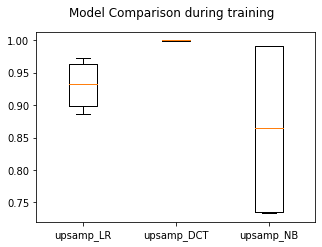

In [53]:
# Algorithm comparison
fig = plt.figure(figsize=(5,3.5))
fig.suptitle('Model Comparison during training')
ax = fig.add_subplot(111)
plt.boxplot(upsamp_results)
ax.set_xticklabels(names)
fig.savefig("comparison.png" , dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()

In [37]:
##apply logistic regression to the train data

LR=LogisticRegression(max_iter=1000)
                
kF= KFold(n_splits=10, random_state=None, shuffle=False)
LR.fit(upsampling_X, upsampling_y)
LR_predictions=LR.predict(X_test_t)

score=roc_auc_score(Y_test, LR_predictions)
print("Accuracy Score of LR is: ", score)

LR_predictions
print(accuracy_score(Y_test,LR_predictions))

from sklearn.metrics import classification_report
print(classification_report(Y_test, LR_predictions))

Accuracy Score of LR is:  0.9451377268972528
0.9740411736479291
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85288
           1       0.06      0.92      0.11       155

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.97      0.99     85443



In [38]:

##Apply Decision Tree for train and test
DT=DecisionTreeClassifier()
                
kF= KFold(n_splits=10, random_state=None, shuffle=False)
DT.fit(upsampling_X, upsampling_y)
DT_predictions=DT.predict(X_test_t)

score=roc_auc_score(Y_test, DT_predictions)
print(" Accuracy Score of DT is: ", score)

 
print(accuracy_score(Y_test, DT_predictions))

from sklearn.metrics import classification_report
print(classification_report(Y_test, DT_predictions))

 Accuracy Score of DT is:  0.8804223866913168
0.9991222218320986
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85288
           1       0.76      0.76      0.76       155

    accuracy                           1.00     85443
   macro avg       0.88      0.88      0.88     85443
weighted avg       1.00      1.00      1.00     85443



In [39]:
##apply Naive Bayes to the train data and test it

NB=GaussianNB() 
                
kF= KFold(n_splits=10, random_state=None, shuffle=False)
NB.fit(upsampling_X, upsampling_y)
NB_predictions=NB.predict(X_test_t)

score=roc_auc_score(Y_test, NB_predictions)
print("Accuracy Score of NB is: ", score)

 
print(accuracy_score(Y_test, NB_predictions))

from sklearn.metrics import classification_report
print(classification_report(Y_test, NB_predictions))

Accuracy Score of NB is:  0.8922952516104826
0.9906838477113398
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85288
           1       0.14      0.79      0.24       155

    accuracy                           0.99     85443
   macro avg       0.57      0.89      0.62     85443
weighted avg       1.00      0.99      0.99     85443



In [40]:
## Apply Unsupervised Learning Method Isolation Forest

#Feature Selection using Z-test
''' 
Valid transactions as our population
Fraud transactions as sample
Two tailed Z-test
Level of significance 0.01
Corresponding critical value is 2.58
'''

' \nValid transactions as our population\nFraud transactions as sample\nTwo tailed Z-test\nLevel of significance 0.01\nCorresponding critical value is 2.58\n'

In [41]:
def ztest(feature):
    
    mean = normal[feature].mean()
    std = fraud[feature].std()
    zScore = (fraud[feature].mean() - mean) / (std/np.sqrt(sample_size))
    
    return zScore

In [42]:

columns= data.drop('Class', axis=1).columns
normal= data[data.Class==0]
fraud= data[data.Class==1]
sample_size=len(fraud)
significant_features=[]
cvalue=2.58 # it is ideal value


for i in columns:
    
    z_value=ztest(i)
    
    if( abs(z_value) >= cvalue):    
        print(i," is statistically significant") #Reject Null hypothesis. i.e. H0
        significant_features.append(i)

V1  is statistically significant
V2  is statistically significant
V3  is statistically significant
V4  is statistically significant
V5  is statistically significant
V6  is statistically significant
V7  is statistically significant
V9  is statistically significant
V10  is statistically significant
V11  is statistically significant
V12  is statistically significant
V14  is statistically significant
V16  is statistically significant
V17  is statistically significant
V18  is statistically significant
V19  is statistically significant
V20  is statistically significant
V21  is statistically significant
V24  is statistically significant
V27  is statistically significant
V28  is statistically significant
PCATime  is statistically significant
PCA amount  is statistically significant


In [43]:
significant_features.append('Class')
data= data[significant_features]
print(data.shape)

(284807, 24)


In [44]:

##verify fraud and non-fraud
Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))

0.0017304750013189597
Fraud Cases: 492
Valid Transactions: 284315


In [45]:
columns = data.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]

# Store the variable we'll be predicting on
target = "Class"

X = data[columns]
Y = data[target]

# Print shapes
print(X.shape)
print(Y.shape)

(284807, 23)
(284807,)


In [47]:

## Applying Isolation Forest
from sklearn.ensemble import IsolationForest
state= 42
IF = IsolationForest(n_estimators = 1050, max_features = 1.0, max_samples=1.0, 
                        behaviour="new", bootstrap=False, random_state=22,
                        contamination = outlier_fraction)
#ISF = IsolationForest(random_state=state)
IF.fit(X)

scores_prediction = IF.decision_function(X)
y_pred = IF.predict(X)


#Reshape the prediction values 
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != Y).sum()

from sklearn.metrics import classification_report,accuracy_score
print("Accuracy Score :")
print(accuracy_score(Y,y_pred))
print("Classification Report :")
print(classification_report(Y,y_pred))

/opt/anaconda/envs/tfgpu-3.6.8/lib/python3.6/site-packages/sklearn/ensemble/_iforest.py:255: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


Accuracy Score :
0.9978336206624135
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.37      0.37      0.37       492

    accuracy                           1.00    284807
   macro avg       0.69      0.69      0.69    284807
weighted avg       1.00      1.00      1.00    284807

